# Load Libraries

In [ ]:
import os 
import pandas as pd
import numpy as np 
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import gc 
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.exceptions import UndefinedMetricWarning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import matplotlib.pyplot as plt
%matplotlib inline
#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()

import dill as pickle 
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, PrecisionRecallDisplay, ConfusionMatrixDisplay, classification_report

<Figure size 432x216 with 0 Axes>

# Load data

In [ ]:
# Remove this code 
import os 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Loading data
train_df = pd.read_pickle('train_df')
test_df = pd.read_pickle('test_df')

train_df.reset_index(drop = True,inplace = True)
test_df.reset_index(drop = True,inplace = True)

In [ ]:
#weight scaling for pos label (to be used later in optuna)
scale_pos_weight = len(train_df[train_df.isFraud == False])/len(train_df[train_df.isFraud == True])

## Split Data

In [ ]:
train = train_df.drop("isFraud", axis=1)
train_labels = train_df["isFraud"].copy()

In [ ]:
test = test_df.drop("isFraud", axis=1) # drop labels for test set
test_labels = test_df["isFraud"].copy()

## Helper Functions

### Sniff

In [ ]:
# Check datatype and percentage of missing values in each column 
def sniff(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = df.iloc[0]
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        return info.sort_values('percent missing')

### Data Type seprator

In [ ]:
def dtype_sep(df):
  """
  Function returns seperate list of columns of dataframe based on datatype

  Parameter and type: 
    df(Pandas Dataframe): Dataframe

  Return:
    :rtype: Tuple
    :return: Tuple of lists, where each list has the column names of same dtype
  """
  num_cols = []
  obj_cols = []
  date_cols = []
  bool_cols = []
  category_cols = []

  for col in df:
    if df[col].dtype in ['int8','int32','int64','float16','float32','float64']:
      num_cols.append(col)

    elif df[col].dtype in ('object','bool','category'):
      obj_cols.append(col)

    elif df[col].dtype == 'datetime64[ns]':
      date_cols.append(col)

  return (num_cols,obj_cols,date_cols)

### Add and drop features

In [ ]:
#prepare new features and delete features no longer needed (common for all models)

cols_to_drop = ['accountNumber','customerId','cardCVV','enteredCVV','cardLast4Digits',
                'transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange'] 

def add_features(df):
  df = df.copy()
  df["txn_year"] = df['transactionDateTime'].dt.year
  df["txn_month"] = df['transactionDateTime'].dt.month
  df["txn_dayofmonth"] = df['transactionDateTime'].dt.day
  df["txn_dayofweek"] = df['transactionDateTime'].dt.dayofweek
  df["txn_dayofyear"] = df['transactionDateTime'].dt.dayofyear
  df["txn_quarter"] = df['transactionDateTime'].dt.quarter
  df["txn_hour"] = df['transactionDateTime'].dt.hour
  df["txn_weekofyear"] = df['transactionDateTime'].dt.isocalendar().week.astype('int64')
  df['cvv_match'] = (df['cardCVV'] == df['enteredCVV']).astype('object')
  df['card_age'] = (df['currentExpDate'] - df['accountOpenDate']).dt.days
  df['account_age'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
  df['merchantName'] = df.merchantName.str.split('#').str[0].str.strip()

  df['cardPresent'] = df['cardPresent'].astype('object')
  df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype('object')
  
  df.drop(cols_to_drop,axis = 'columns',inplace = True)

  return df

### Feature Importance

In [ ]:
def feature_importance(grid_search):
    """ Plots feature importance"""
    feature_importance = pd.Series(grid_search.feature_importances_, index = train_prepared_cols)
    plt.figure(figsize = (10,10))
    feature_importance.sort_values().plot.barh()
    plt.grid(False)
    plt.show()

### Train Model Result

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, average_precision_score, PrecisionRecallDisplay, RocCurveDisplay,ConfusionMatrixDisplay, classification_report

def train_model_results(model_name, model, X_train, y_train):
    """Get's the model results that I want for this specific problem"""

    print("Training Results for " + model_name)
    print()
    print("-------------------------------------------------------------")

    # predict labels for train data 
    y_train_predict = model.predict(X_train)

    # predict probability for train data 
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]

    # We are optimizing on mean average precision, thus score will return AP(average precision)
    print(f"Training Accuracy: {model.score(X_train, y_train)}") 
    
    # ROC-AUC Score 
    print(f"Training ROC AUC Score: {roc_auc_score(y_train, y_train_pred_prob)}")

    #AP Score
    print(f"Training AP Score: {average_precision_score(y_train, y_train_pred_prob)}")
    print("-------------------------------------------------------------")
    print("Training classification report :")
    print(classification_report(y_train,y_train_predict, target_names=["Non-Fraud", "Fraud"]))

    print("-------------------------------------------------------------")
    #Plot ROC AUC Curve
    print("Training ROC Curve :")
    RocCurveDisplay.from_estimator(model, X_train, y_train)
    plt.show()
    print("-------------------------------------------------------------")
    # Plot PR Curve
    print("Training Precision-Recall Curve :")
    PrecisionRecallDisplay.from_estimator(model, X_train, y_train)
    plt.show()
    print("-------------------------------------------------------------")
    # Plotting confusion Matrices
    ConfusionMatrixDisplay.from_estimator(model, 
                                          X_train, 
                                          y_train,
                                          display_labels=["Non-Fraud", "Fraud"], 
                                          cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()

### Test Model Result

In [ ]:
def test_model_results(model_name, model,test_data):
    """Get's the model results that I want for this specific problem"""

    print("Testing Results for " + model_name)
    print()
    print("-------------------------------------------------------------")


    # predict labels for test data 
    test_labels_predict = model.predict(test_data)

    # predict probability for test data 
    test_pred_prob = model.predict_proba(test_data)[:, 1]

    # We are optimizing on mean average precision, thus score will return AP(average precision)
    print(f"Testing Accuracy: {model.score(test_data, test_labels)}") 
    
    # ROC-AUC Score 
    print(f"Testing ROC AUC Score: {roc_auc_score(test_labels, test_pred_prob)}")
    #AP Score
    print(f"Testing AP Score: {average_precision_score(test_labels, test_pred_prob)}")
    print("-------------------------------------------------------------")
    print("Testing classification report :")
    print(classification_report(test_labels,test_labels_predict, target_names=["Non-Fraud", "Fraud"]))

    print("-------------------------------------------------------------")
    #Plot ROC AUC Curve
    print("Testing ROC Curve :")
    RocCurveDisplay.from_estimator(model, test_data, test_labels)
    plt.show()
    print("-------------------------------------------------------------")

    # Plot PR Curve
    print("Testing Precision-Recall Curve :")
    PrecisionRecallDisplay.from_estimator(model, test_data, test_labels)
    plt.show()
    print("-------------------------------------------------------------")
    
    # Plotting confusion Matrices
    ConfusionMatrixDisplay.from_estimator(model, 
                                          test_data, 
                                          test_labels,
                                          display_labels=["Non-Fraud", "Fraud"], 
                                          cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()

### Save model

In [ ]:
from datetime import datetime

def save_model(model_grid, f_name):
  dir = "/content/drive/MyDrive/"
  file_name = dir + f_name + "_"+ str(datetime.now().isoformat(timespec='minutes') ) +".pkl"
  joblib.dump(model_grid, file_name)

In [ ]:
train_add_features = add_features(train)
test_add_features = add_features(test)

In [ ]:
train_prepared_cols = train_add_features.columns.to_list()

In [ ]:
train_add_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629090 entries, 0 to 629089
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               629090 non-null  int64  
 1   availableMoney            629090 non-null  float64
 2   transactionAmount         629090 non-null  float64
 3   merchantName              629090 non-null  object 
 4   acqCountry                625420 non-null  object 
 5   merchantCountryCode       628519 non-null  object 
 6   posEntryMode              625836 non-null  object 
 7   posConditionCode          628774 non-null  object 
 8   merchantCategoryCode      629090 non-null  object 
 9   transactionType           628526 non-null  object 
 10  currentBalance            629090 non-null  float64
 11  cardPresent               629090 non-null  object 
 12  expirationDateKeyInMatch  629090 non-null  object 
 13  txn_year                  629090 non-null  i

## Preparation for Logistic Regression

In [ ]:
train_lr = train_add_features.copy()
test_lr = test_add_features.copy()

Logistic Regression:

1) Cols drop
2) New Features
4) Standard Scalar
3) One Hot Encoding
5) Numerical Cols Transformation

### Prepare Data

In [ ]:
num_cols,obj_cols,date_cols = dtype_sep(train_lr) 

In [ ]:
sniff(train_lr)

,sample,data type,percent missing
creditLimit,5000,int64,0.000000
cvv_match,True,object,0.000000
txn_weekofyear,38,int64,0.000000
txn_hour,17,int64,0.000000
txn_quarter,3,int64,0.000000
txn_dayofyear,268,int64,0.000000
txn_dayofweek,5,int64,0.000000
txn_dayofmonth,24,int64,0.000000
txn_month,9,int64,0.000000
txn_year,2016,int64,0.000000


#### Impute Missing Values

In [ ]:
from sklearn.impute import SimpleImputer

def imputer(imputation_stats):
    if imputation_stats == "median":
      imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    if imputation_stats == "mode":
      imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    
    return imputer 
    

def impute_missingness(df, columns, imputer, dataset_name):
  
  df_imputed = df.copy()
  
  for col in columns: 
    if df[col].dtype == 'datetime64[ns]':
      df[col] = df[col].astype('object')
    
    if dataset_name == "train":
        df_imputed[col] = imputer.fit_transform(df[col].values.reshape(-1,1))[:,0]
    else:
        df_imputed[col] = imputer.transform(df[col].values.reshape(-1,1))[:,0]

  return df_imputed

In [ ]:
train_lr.head()

,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,...,txn_month,txn_dayofmonth,txn_dayofweek,txn_dayofyear,txn_quarter,txn_hour,txn_weekofyear,cvv_match,card_age,account_age
0,5000,935.22,50.45,Texas Gas,US,US,05,01,fuel,PURCHASE,...,9,24,5,268,3,17,38,True,5709,285
1,250,133.29,146.02,Rodeway Inn,US,US,90,08,hotels,PURCHASE,...,10,17,0,291,4,7,42,True,1875,460
2,7500,6922.03,373.71,Hardee's,US,US,05,01,fastfood,PURCHASE,...,4,1,4,92,2,10,13,True,3767,662
3,5000,693.49,499.83,Ricks Repair,US,US,05,01,auto,PURCHASE,...,11,19,5,324,4,18,46,True,7011,2312
4,5000,364.17,39.22,Auntie Anne's,US,US,09,01,fastfood,PURCHASE,...,9,28,2,272,3,15,39,True,6423,637


In [ ]:
cat_imputer = imputer("mode")
numerical_imputer = imputer("median")

## train data imputation for logistic regression

#Impute NUMERICAL variables 
train_imputed_lr = impute_missingness(train_lr, num_cols, numerical_imputer, "train")

#Impute categorical variables 
train_imputed_lr = impute_missingness(train_imputed_lr, obj_cols, cat_imputer, "train")

## test data imputation for logistic regression

#Impute NUMERICAL variables 
test_imputed_lr = impute_missingness(test_lr, num_cols, numerical_imputer, "test")

#Impute categorical variables 
test_imputed_lr = impute_missingness(test_imputed_lr, obj_cols, cat_imputer, "test")

#### Standard Scaling and One-Hot Encoding

In [ ]:
#scaling and one-hot encoding []
def preprocess(train_df,test_df):

  num_cols,obj_cols,date_cols = dtype_sep(train_df)

  #standard sclaing
  sc = StandardScaler()

  train_scaled = pd.DataFrame(sc.fit_transform(train_df[num_cols]), index=train_df.index)
  train_scaled.columns = num_cols

  test_scaled = pd.DataFrame(sc.transform(test_df[num_cols]),index=test_df.index)
  test_scaled.columns = num_cols

  #OH Encoding
  oh_enc = OneHotEncoder(handle_unknown='ignore')

  train_encoded = pd.DataFrame(oh_enc.fit_transform(train_df[obj_cols]).toarray(),index =train_df.index)

  feature_names = []
  for i,col in enumerate(oh_enc.feature_names_in_):
    for cat in oh_enc.categories_[i]:
      feature_names.append(col + "_"+ str(cat))

  train_encoded.columns = feature_names


  test_encoded = pd.DataFrame(oh_enc.transform(test_df[obj_cols]).toarray(),index =test_df.index)
  test_encoded.columns = feature_names

  #Concatenate the two dataframes : 
  train_prepared = pd.concat([train_scaled, train_encoded], axis=1)
  test_prepared = pd.concat([test_scaled, test_encoded], axis=1)

  return train_prepared,test_prepared,sc,oh_enc  

In [ ]:
train_preprocessed_lr,test_preprocess_lr,sc_lr,oh_enc_lr = preprocess(train_imputed_lr,test_imputed_lr)

### Train Model

In [ ]:
# Stratified K-folds of CV
kfold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import time

start_time = time.time()

param_grid = [{'penalty' : ['l2'],
              'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'class_weight':[{1: w} for w in [20,30,40,60]]}]

cls_lr = LogisticRegression(random_state=42, n_jobs=-1)

# train across 5 folds 
grid_search_lr = RandomizedSearchCV(cls_lr, param_grid, cv=kfold_cv,
                          scoring=('roc_auc', 'average_precision','recall','precision','f1'), 
                          refit = 'average_precision',
                          return_train_score=True,n_iter=15)

grid_search_lr.fit(train_preprocessed_lr, train_labels)

print("elapsed time in seconds: ", time.time() - start_time)

elapsed time in seconds:  2764.8795211315155


#### Save Best Model

In [ ]:
#save model
save_model(grid_search_lr, "logistic")

In [ ]:
# load model
grid_search_lr = joblib.load('logistic_2023-02-18T08:00.pkl')

#### Best Model after Grid Search

In [ ]:
print(f"Best Hyperparameters: {grid_search_lr.best_params_}")
print(f"validation Mean Average Precision: {grid_search_lr.best_score_}")

Best Hyperparameters: {'penalty': 'l2', 'class_weight': {1: 20}, 'C': 0.1}
validation Mean Average Precision: 0.05737611464040408


#### Cross Validation Result

In [ ]:
cvres = grid_search_lr.cv_results_ 

In [ ]:
cvres_df = pd.DataFrame(cvres)
# Select required Columns
cvres_df = cvres_df[['params',
          'mean_train_average_precision','mean_train_roc_auc','mean_train_recall', 'mean_train_precision','mean_train_f1', 
          'mean_test_average_precision','mean_test_roc_auc','mean_test_recall','mean_test_precision', 'mean_test_f1', 
          'mean_fit_time']]

# Rename Columns 
cvres_df.rename(columns={"mean_train_average_precision": "Train_AP", "mean_train_roc_auc": "Train_ROC_AUC", 
                         "mean_train_recall": "Train_Recall","mean_train_precision": "Train_Precision", "mean_train_f1": "Train_F1",
                         "mean_test_average_precision": "Val_AP", "mean_test_roc_auc": "Val_ROC_AUC", 
                         "mean_test_recall": "Val_Recall","mean_test_precision": "Val_Precision", "mean_test_f1": "Val_F1"}, inplace=True)
cvres_df.round(2)

,params,Train_AP,Train_ROC_AUC,Train_Recall,Train_Precision,Train_F1,Val_AP,Val_ROC_AUC,Val_Recall,Val_Precision,Val_F1,mean_fit_time
0,"{'penalty': 'l2', 'class_weight': {1: 40}, 'C'...",0.06,0.77,0.54,0.05,0.09,0.06,0.76,0.53,0.05,0.08,33.58
1,"{'penalty': 'l2', 'class_weight': {1: 40}, 'C'...",0.06,0.76,0.51,0.05,0.09,0.06,0.76,0.50,0.05,0.09,32.55
2,"{'penalty': 'l2', 'class_weight': {1: 60}, 'C'...",0.06,0.77,0.72,0.03,0.07,0.06,0.76,0.71,0.03,0.07,32.34
3,"{'penalty': 'l2', 'class_weight': {1: 20}, 'C'...",0.06,0.77,0.24,0.08,0.12,0.06,0.76,0.24,0.08,0.11,34.18
4,"{'penalty': 'l2', 'class_weight': {1: 20}, 'C'...",0.06,0.77,0.24,0.08,0.12,0.06,0.76,0.24,0.08,0.11,33.76
5,"{'penalty': 'l2', 'class_weight': {1: 40}, 'C'...",0.06,0.77,0.55,0.05,0.08,0.06,0.76,0.54,0.05,0.08,34.21
6,"{'penalty': 'l2', 'class_weight': {1: 60}, 'C'...",0.06,0.77,0.72,0.04,0.07,0.06,0.76,0.71,0.03,0.07,34.21
7,"{'penalty': 'l2', 'class_weight': {1: 30}, 'C'...",0.06,0.77,0.40,0.06,0.10,0.06,0.76,0.40,0.06,0.10,34.58
8,"{'penalty': 'l2', 'class_weight': {1: 60}, 'C'...",0.06,0.77,0.72,0.03,0.07,0.06,0.76,0.71,0.03,0.07,33.96
9,"{'penalty': 'l2', 'class_weight': {1: 40}, 'C'...",0.06,0.77,0.55,0.05,0.08,0.06,0.76,0.54,0.05,0.08,34.64


Training Results for Logistic Regression

-------------------------------------------------------------
Training Accuracy: 0.05828599729291953
Training ROC AUC Score: 0.7698263952353707
Training AP Score: 0.05828599729291953
-------------------------------------------------------------
Training classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.95      0.97    619156
       Fraud       0.08      0.24      0.12      9934

    accuracy                           0.94    629090
   macro avg       0.53      0.60      0.54    629090
weighted avg       0.97      0.94      0.96    629090

-------------------------------------------------------------
Training ROC Curve :


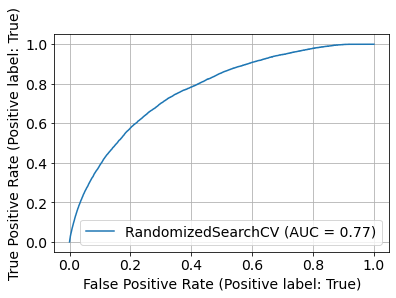

-------------------------------------------------------------
Training Precision-Recall Curve :


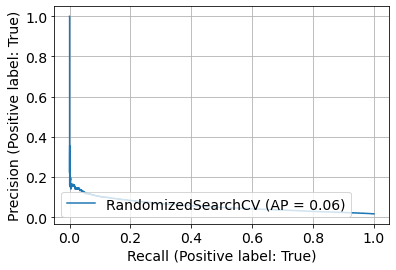

-------------------------------------------------------------


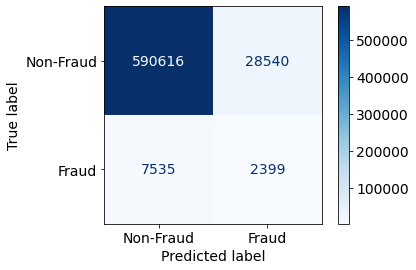

In [ ]:
train_model_results("Logistic Regression",grid_search_lr, train_preprocessed_lr, train_labels)

Testing Results for Logistic Regression

-------------------------------------------------------------
Testing Accuracy: 0.058212725982883004
Testing ROC AUC Score: 0.7692449518538844
Testing AP Score: 0.058212725982883004
-------------------------------------------------------------
Testing classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.95      0.97    154790
       Fraud       0.08      0.25      0.12      2483

    accuracy                           0.94    157273
   macro avg       0.53      0.60      0.55    157273
weighted avg       0.97      0.94      0.96    157273

-------------------------------------------------------------
Testing ROC Curve :


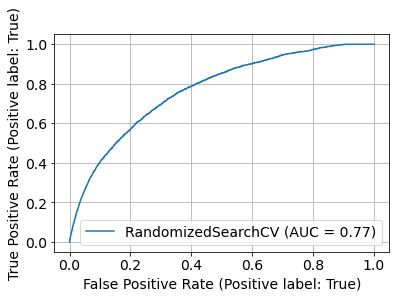

-------------------------------------------------------------
Testing Precision-Recall Curve :


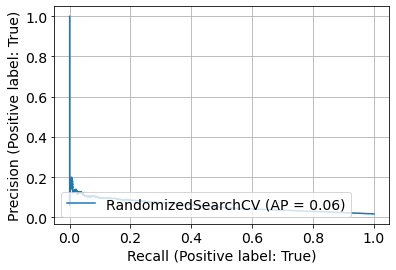

-------------------------------------------------------------


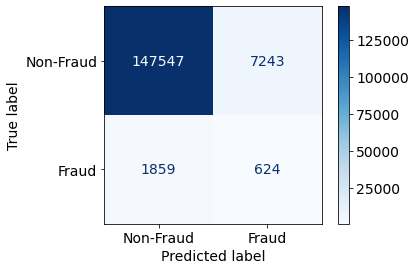

In [ ]:
test_model_results("Logistic Regression",grid_search_lr,test_preprocess_lr)

## Random Forest

### Prepare Data

In [ ]:
train_rf = train_add_features.copy()
test_rf = test_add_features.copy()

### Prepare Data

In [ ]:
num_cols,obj_cols,date_cols = dtype_sep(train_rf) 

In [ ]:
!pip install -U scikit-learn

#### Ordinal Encoding

In [ ]:
# Ordinal Encoding
def preprocess(train_df,test_df):

  num_cols,obj_cols,date_cols = dtype_sep(train_df)

  #ordinal encoder
  ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = -1,encoded_missing_value = -1)

  train_encoded = pd.DataFrame(ord_enc.fit_transform(train_df[obj_cols]),index =train_df.index,columns = obj_cols)
  test_encoded = pd.DataFrame(ord_enc.transform(test_df[obj_cols]),index =test_df.index,columns = obj_cols)

  #Concatenate the two dataframes: 
  train_prepared = pd.concat([train_df[num_cols], train_encoded], axis=1)
  test_prepared = pd.concat([test_df[num_cols], test_encoded], axis=1)

  return train_prepared,test_prepared,ord_enc

**Rf can't handle NaN values. So missing values have to be given a dummy value like -1,-999 or 'Empty' etc. which does not coincide with any data value in the dataset**

In [ ]:
train_prepared_rf,test_prepared_rf,ord_enc_rf = preprocess(train_rf,test_rf)

In [ ]:
train_prepared_rf.shape,test_prepared_rf.shape

((629090, 24), (157273, 24))

### Train Model

In [ ]:
# Stratified K-folds of CV
kfold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()

#Check which hyperparamtwers to use and their range

param_grid = [{'n_estimators': [150], 
                'max_features': [4,5,6,7,9],                             
                'max_depth': [5,7,9],
                'class_weight':[{1: w} for w in [40,60]]}]   

cls_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# train across 5 folds 
grid_search_rf = RandomizedSearchCV(cls_rf, param_grid, cv=kfold_cv,
                          scoring=('roc_auc', 'average_precision','recall','precision','f1'), 
                          refit = 'average_precision',
                          return_train_score=True,n_iter=20)

grid_search_rf.fit(train_prepared_rf, train_labels)

print("elapsed time in seconds: ", time.time() - start_time)

#### Save Best Model

In [ ]:
#save model
save_model(grid_search_rf, "random_forest")

In [ ]:
# load model
grid_search_rf = joblib.load('random_forest_2023-02-21T00:28.pkl')

#### Best Model after Grid Search

In [ ]:
print(f"Best Hyperparameters: {grid_search_rf.best_params_}")
print(f"validation Mean Average Precision: {grid_search_rf.best_score_}")

Best Hyperparameters: {'n_estimators': 150, 'max_features': 9, 'max_depth': 9, 'class_weight': {1: 40}}
validation Mean Average Precision: 0.06877476351690778


#### Cross Validation Result

In [ ]:
cvres = grid_search_rf.cv_results_ 

In [ ]:
cvres_df = pd.DataFrame(cvres)
# Select required Columns
cvres_df = cvres_df[['params',
          'mean_train_average_precision','mean_train_roc_auc','mean_train_recall', 'mean_train_precision','mean_train_f1', 
          'mean_test_average_precision','mean_test_roc_auc','mean_test_recall','mean_test_precision', 'mean_test_f1', 
          'mean_fit_time']]

# Rename Columns 
cvres_df.rename(columns={"mean_train_average_precision": "Train_AP", "mean_train_roc_auc": "Train_ROC_AUC", 
                         "mean_train_recall": "Train_Recall","mean_train_precision": "Train_Precision", "mean_train_f1": "Train_F1",
                         "mean_test_average_precision": "Val_AP", "mean_test_roc_auc": "Val_ROC_AUC", 
                         "mean_test_recall": "Val_Recall","mean_test_precision": "Val_Precision", "mean_test_f1": "Val_F1"}, inplace=True)
cvres_df.round(2)

,params,Train_AP,Train_ROC_AUC,Train_Recall,Train_Precision,Train_F1,Val_AP,Val_ROC_AUC,Val_Recall,Val_Precision,Val_F1,mean_fit_time
0,"{'n_estimators': 150, 'max_features': 4, 'max_...",0.07,0.78,0.45,0.06,0.11,0.06,0.76,0.42,0.06,0.10,124.93
1,"{'n_estimators': 150, 'max_features': 9, 'max_...",0.06,0.76,0.65,0.04,0.07,0.06,0.75,0.64,0.04,0.07,183.85
2,"{'n_estimators': 150, 'max_features': 9, 'max_...",0.10,0.84,0.55,0.07,0.12,0.07,0.79,0.47,0.06,0.10,299.26
3,"{'n_estimators': 150, 'max_features': 7, 'max_...",0.06,0.76,0.65,0.04,0.07,0.06,0.75,0.64,0.03,0.07,150.29
4,"{'n_estimators': 150, 'max_features': 4, 'max_...",0.07,0.78,0.66,0.04,0.07,0.06,0.76,0.63,0.04,0.07,129.97
5,"{'n_estimators': 150, 'max_features': 6, 'max_...",0.07,0.79,0.47,0.06,0.10,0.06,0.77,0.45,0.06,0.10,175.49
6,"{'n_estimators': 150, 'max_features': 6, 'max_...",0.07,0.79,0.67,0.04,0.08,0.06,0.77,0.63,0.04,0.07,174.85
7,"{'n_estimators': 150, 'max_features': 9, 'max_...",0.09,0.84,0.71,0.05,0.10,0.07,0.78,0.62,0.05,0.09,297.14
8,"{'n_estimators': 150, 'max_features': 7, 'max_...",0.07,0.79,0.49,0.06,0.10,0.06,0.77,0.46,0.05,0.10,203.51
9,"{'n_estimators': 150, 'max_features': 9, 'max_...",0.07,0.79,0.67,0.04,0.08,0.06,0.77,0.64,0.04,0.08,242.10


Training Results for Random Forest

-------------------------------------------------------------
Training Accuracy: 0.09552065856157829
Training ROC AUC Score: 0.833980451620144
Training AP Score: 0.09552065856157829
-------------------------------------------------------------
Training classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.87      0.93    619156
       Fraud       0.06      0.55      0.11      9934

    accuracy                           0.87    629090
   macro avg       0.53      0.71      0.52    629090
weighted avg       0.98      0.87      0.91    629090

-------------------------------------------------------------
Training ROC Curve :


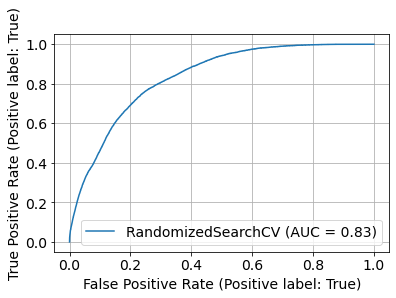

-------------------------------------------------------------
Training Precision-Recall Curve :


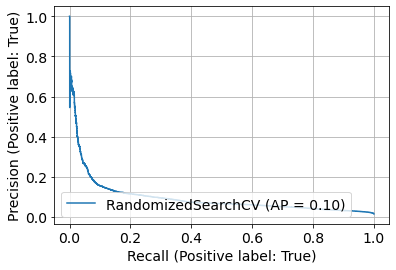

-------------------------------------------------------------


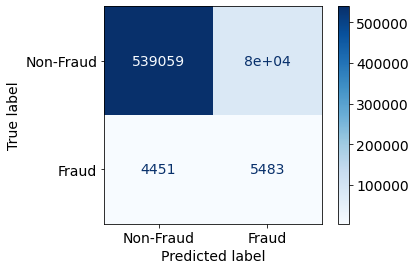

In [ ]:
train_model_results("Random Forest",grid_search_rf, train_prepared_rf, train_labels)

Testing Results for Random Forest

-------------------------------------------------------------
Testing Accuracy: 0.06680616724340235
Testing ROC AUC Score: 0.7850897336463831
Testing AP Score: 0.06680616724340235
-------------------------------------------------------------
Testing classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.87      0.93    154790
       Fraud       0.06      0.48      0.10      2483

    accuracy                           0.86    157273
   macro avg       0.52      0.68      0.51    157273
weighted avg       0.98      0.86      0.91    157273

-------------------------------------------------------------
Testing ROC Curve :


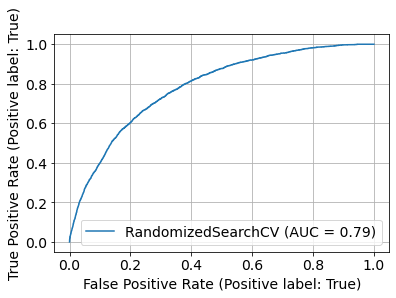

-------------------------------------------------------------
Testing Precision-Recall Curve :


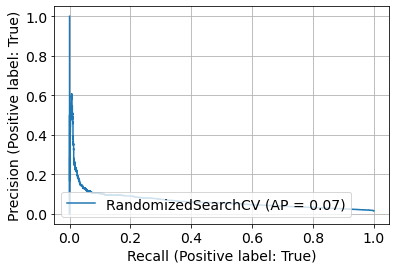

-------------------------------------------------------------


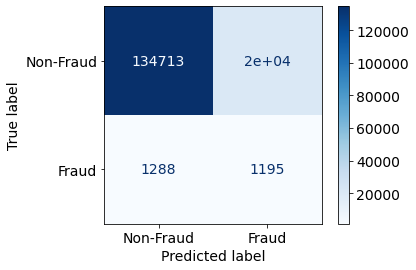

In [ ]:
test_model_results("Random Forest",grid_search_rf,test_prepared_rf)

In [ ]:
grid_search_rf.best_estimator_.feature_importances_

array([3.23167944e-02, 2.74109243e-02, 3.15283967e-01, 3.76914101e-02,
       0.00000000e+00, 3.26909944e-03, 1.01135497e-02, 4.58987499e-03,
       1.46506022e-02, 1.06094683e-03, 9.81961714e-03, 9.07876100e-03,
       1.92397687e-02, 4.45432714e-02, 8.23263738e-02, 1.94800019e-03,
       3.06283254e-03, 1.60190403e-01, 5.29729617e-03, 1.33242074e-01,
       3.59670894e-03, 7.99759617e-02, 2.30248045e-04, 1.06151520e-03])

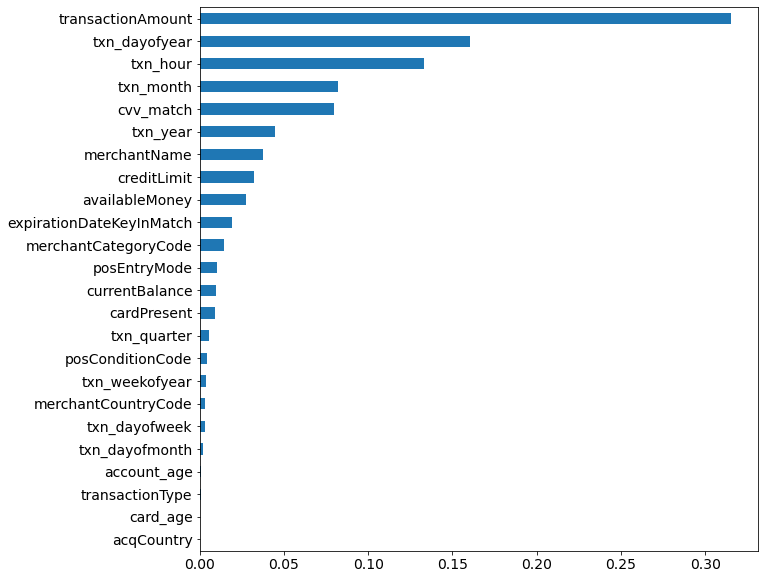

In [ ]:
feature_importance(grid_search_rf.best_estimator_)

## XGBoost

### Prepare Data

In [ ]:
train_xgb = train_add_features.copy()
test_xgb = test_add_features.copy()

### Prepare Data

In [ ]:
num_cols,obj_cols,date_cols = dtype_sep(train_xgb) 

#### Ordinal Encoding

In [ ]:
# Ordinal Encoding
def preprocess(train_df,test_df):

  num_cols,obj_cols,date_cols = dtype_sep(train_df)

  #ordinal encoder
  ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = -1,encoded_missing_value = -1)

  train_encoded = pd.DataFrame(ord_enc.fit_transform(train_df[obj_cols]),index =train_df.index,columns = obj_cols)
  test_encoded = pd.DataFrame(ord_enc.transform(test_df[obj_cols]),index =test_df.index,columns = obj_cols)

  #Concatenate the two dataframes: 
  train_prepared = pd.concat([train_df[num_cols], train_encoded], axis=1)
  test_prepared = pd.concat([test_df[num_cols], test_encoded], axis=1)

  return train_prepared,test_prepared,ord_enc

In [ ]:
train_prepared_xgb,test_prepared_xgb,ord_enc_xgb = preprocess(train_xgb,test_xgb)

In [ ]:
train_prepared_xgb.shape,test_prepared_xgb.shape

((629090, 24), (157273, 24))

### Train Model

In [ ]:
# Stratified K-folds of CV
kfold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Check which hyperparamtwers to use and their range**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import time

start_time = time.time()

#Check which hyperparamtwers to use and their range
param_grid = [{'n_estimators': [100,200,300], 
                'learning_rate': [0.01,0.05,0.1,0.15,0.2],                                       
                'max_depth': range (3, 10),
                'class_weight':[{1: w} for w in [10,20,30,40]]}]

cls_xgb = XGBClassifier(random_state=42, n_jobs=-1)

# train across 5 folds 
grid_search_xgb = RandomizedSearchCV(cls_xgb, param_grid, cv=kfold_cv,
                          scoring=('roc_auc', 'average_precision','recall','precision','f1'), 
                          refit = 'average_precision',
                          return_train_score=True,n_iter = 100)

grid_search_xgb.fit(train_prepared_xgb, train_labels)

print("elapsed time in seconds: ", time.time() - start_time)

elapsed time in seconds:  3.8313844203948975


#### Save Best Model

In [ ]:
#save model
save_model(grid_search_xgb, "xgboost")

In [ ]:
# load model
grid_search_xgb = joblib.load('xgboost_2023-02-16T16:22.pkl')

#### Best Model after Grid Search

In [ ]:
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")
print(f"validation Mean Average Precision: {grid_search_xgb.best_score_}")

Best Hyperparameters: {'scale_pos_weight': 20, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01}
validation Mean Average Precision: 0.06834777547710065


#### Cross Validation Result

In [ ]:
cvres = grid_search_xgb.cv_results_ 

In [ ]:
cvres_df = pd.DataFrame(cvres)
# Select required Columns
cvres_df = cvres_df[['params',
          'mean_train_average_precision','mean_train_roc_auc','mean_train_recall', 'mean_train_precision','mean_train_f1', 
          'mean_test_average_precision','mean_test_roc_auc','mean_test_recall','mean_test_precision', 'mean_test_f1', 
          'mean_fit_time']]

# Rename Columns 
cvres_df.rename(columns={"mean_train_average_precision": "Train_AP", "mean_train_roc_auc": "Train_ROC_AUC", 
                         "mean_train_recall": "Train_Recall","mean_train_precision": "Train_Precision", "mean_train_f1": "Train_F1",
                         "mean_test_average_precision": "Val_AP", "mean_test_roc_auc": "Val_ROC_AUC", 
                         "mean_test_recall": "Val_Recall","mean_test_precision": "Val_Precision", "mean_test_f1": "Val_F1"}, inplace=True)
cvres_df.round(2)

,params,Train_AP,Train_ROC_AUC,Train_Recall,Train_Precision,Train_F1,Val_AP,Val_ROC_AUC,Val_Recall,Val_Precision,Val_F1,mean_fit_time
0,"{'scale_pos_weight': 20, 'n_estimators': 300, ...",0.08,0.79,0.27,0.09,0.13,0.07,0.77,0.25,0.08,0.13,64.56


Training Results for XGBoost

-------------------------------------------------------------
Training Accuracy: 0.07486440293507712
Training ROC AUC Score: 0.7824811004501615
Training AP Score: 0.07486440293507712
-------------------------------------------------------------
Training classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.95      0.97    619156
       Fraud       0.09      0.27      0.13      9934

    accuracy                           0.94    629090
   macro avg       0.54      0.61      0.55    629090
weighted avg       0.97      0.94      0.96    629090

-------------------------------------------------------------
Training ROC Curve :


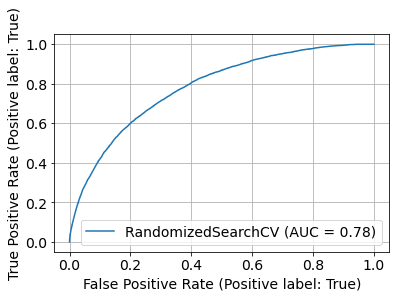

-------------------------------------------------------------
Training Precision-Recall Curve :


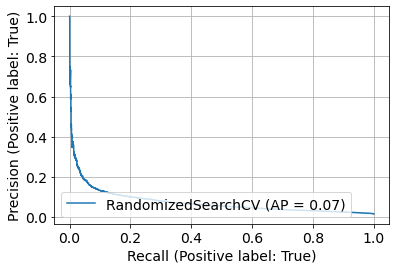

-------------------------------------------------------------


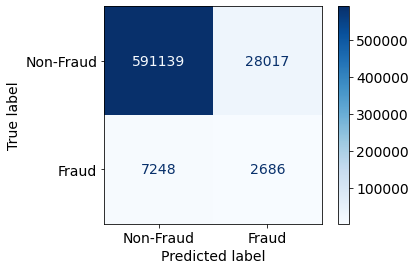

In [ ]:
train_model_results("XGBoost",grid_search_xgb, train_prepared_xgb, train_labels)

Testing Results for XGBoost

-------------------------------------------------------------
Testing Accuracy: 0.06509749311089724
Testing ROC AUC Score: 0.7686555625218343
Testing AP Score: 0.06509749311089724
-------------------------------------------------------------
Testing classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.95      0.97    154790
       Fraud       0.08      0.26      0.13      2483

    accuracy                           0.94    157273
   macro avg       0.54      0.61      0.55    157273
weighted avg       0.97      0.94      0.96    157273

-------------------------------------------------------------
Testing ROC Curve :


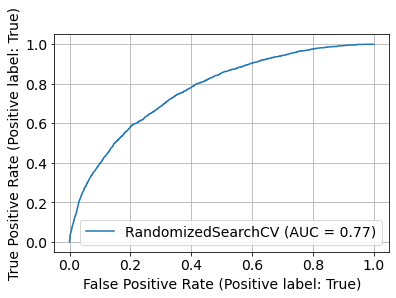

-------------------------------------------------------------
Testing Precision-Recall Curve :


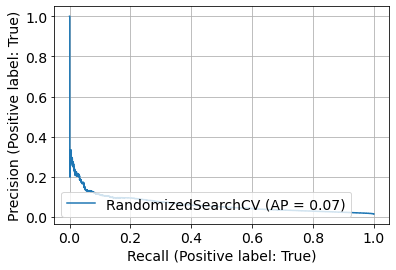

-------------------------------------------------------------


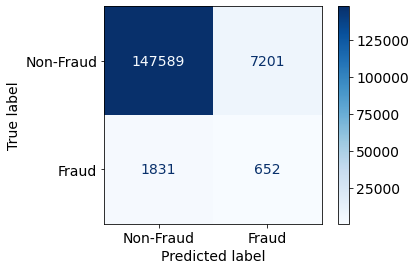

In [ ]:
test_model_results("XGBoost",grid_search_xgb,test_prepared_xgb)

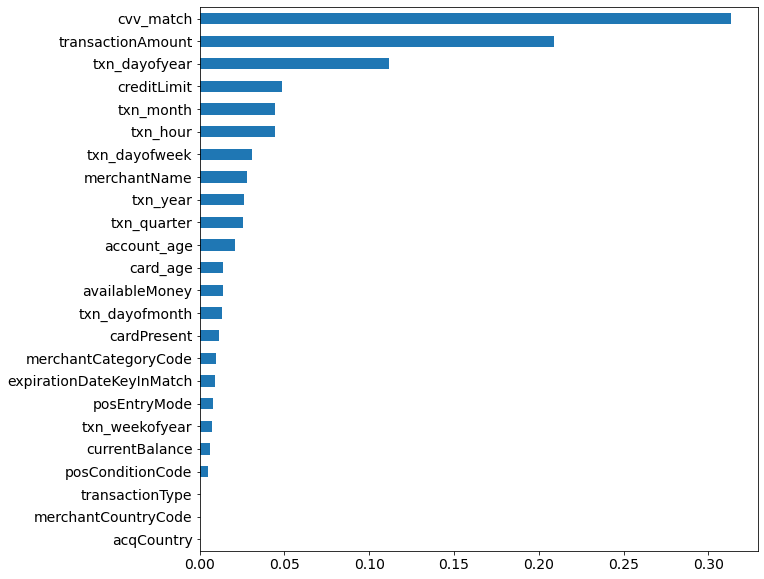

In [ ]:
feature_importance(grid_search_xgb.best_estimator_)

## Adaboost

### Prepare Data

In [ ]:
train_adb = train_add_features.copy()
test_adb = test_add_features.copy()

### Prepare Data

In [ ]:
num_cols,obj_cols,date_cols = dtype_sep(train_adb) 

#### Ordinal Encoding

In [ ]:
# Ordinal Encoding
def preprocess(train_df,test_df):

  num_cols,obj_cols,date_cols = dtype_sep(train_df)

  #ordinal encoder
  ord_enc = OrdinalEncoder(handle_unknown = 'use_encoded_value',unknown_value = -1,encoded_missing_value = -1)

  train_encoded = pd.DataFrame(ord_enc.fit_transform(train_df[obj_cols]),index =train_df.index,columns = obj_cols)
  test_encoded = pd.DataFrame(ord_enc.transform(test_df[obj_cols]),index =test_df.index,columns = obj_cols)

  #Concatenate the two dataframes: 
  train_prepared = pd.concat([train_df[num_cols], train_encoded], axis=1)
  test_prepared = pd.concat([test_df[num_cols], test_encoded], axis=1)

  return train_prepared,test_prepared,ord_enc

In [ ]:
train_prepared_adb,test_prepared_adb,ord_enc_adb = preprocess(train_adb,test_adb)

In [ ]:
train_prepared_adb.shape,test_prepared_adb.shape

((629090, 24), (157273, 24))

### Train Model

In [ ]:
# Stratified K-folds of CV
kfold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**Check which hyperparamtwers to use and their range**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
import time

start_time = time.time()

param_grid = [{'n_estimators': [100,200,300], 
                'learning_rate': [0.001, 0.01, 0.1, 1.0]}]        

adb_cls = AdaBoostClassifier(random_state=42)

# train across 5 folds 
grid_search_adb = RandomizedSearchCV(adb_cls, param_grid, cv=kfold_cv,
                          scoring=('roc_auc', 'average_precision','recall','precision','f1'), 
                          refit = 'average_precision',
                          return_train_score=True,n_iter = 12)

grid_search_adb.fit(train_prepared_adb, train_labels)

print("elapsed time in seconds: ", time.time() - start_time)

elapsed time in seconds:  13751.081258535385


#### Save Best Model

In [ ]:
#save model
save_model(grid_search_adb, "adaboost")

In [ ]:
# load model
grid_search_adb = joblib.load('adaboost_2023-02-03T00:46.pkl')

#### Best Model after Grid Search

In [ ]:
print(f"Best Hyperparameters: {grid_search_adb.best_params_}")
print(f"validation Mean Average Precision: {grid_search_adb.best_score_}")

Best Hyperparameters: {'n_estimators': 300, 'learning_rate': 1.0}
validation Mean Average Precision: 0.06520182967675404


#### Cross Validation Result

In [ ]:
cvres = grid_search_adb.cv_results_ 

In [ ]:
cvres_df = pd.DataFrame(cvres)
# Select required Columns
cvres_df = cvres_df[['params',
          'mean_train_average_precision','mean_train_roc_auc','mean_train_recall', 'mean_train_precision','mean_train_f1', 
          'mean_test_average_precision','mean_test_roc_auc','mean_test_recall','mean_test_precision', 'mean_test_f1', 
          'mean_fit_time']]

# Rename Columns 
cvres_df.rename(columns={"mean_train_average_precision": "Train_AP", "mean_train_roc_auc": "Train_ROC_AUC", 
                         "mean_train_recall": "Train_Recall","mean_train_precision": "Train_Precision", "mean_train_f1": "Train_F1",
                         "mean_test_average_precision": "Val_AP", "mean_test_roc_auc": "Val_ROC_AUC", 
                         "mean_test_recall": "Val_Recall","mean_test_precision": "Val_Precision", "mean_test_f1": "Val_F1"}, inplace=True)
cvres_df.round(2)

,params,Train_AP,Train_ROC_AUC,Train_Recall,Train_Precision,Train_F1,Val_AP,Val_ROC_AUC,Val_Recall,Val_Precision,Val_F1,mean_fit_time
0,"{'n_estimators': 100, 'learning_rate': 0.001}",0.02,0.64,0.0,0.00,0.0,0.02,0.64,0.0,0.00,0.0,92.61
1,"{'n_estimators': 200, 'learning_rate': 0.001}",0.02,0.64,0.0,0.00,0.0,0.02,0.64,0.0,0.00,0.0,186.52
2,"{'n_estimators': 300, 'learning_rate': 0.001}",0.02,0.65,0.0,0.00,0.0,0.02,0.65,0.0,0.00,0.0,286.36
3,"{'n_estimators': 100, 'learning_rate': 0.01}",0.04,0.70,0.0,0.00,0.0,0.04,0.70,0.0,0.00,0.0,97.22
4,"{'n_estimators': 200, 'learning_rate': 0.01}",0.04,0.71,0.0,0.00,0.0,0.04,0.71,0.0,0.00,0.0,193.98
5,"{'n_estimators': 300, 'learning_rate': 0.01}",0.04,0.71,0.0,0.00,0.0,0.04,0.71,0.0,0.00,0.0,288.11
6,"{'n_estimators': 100, 'learning_rate': 0.1}",0.05,0.74,0.0,0.00,0.0,0.05,0.74,0.0,0.00,0.0,98.39
7,"{'n_estimators': 200, 'learning_rate': 0.1}",0.06,0.75,0.0,0.00,0.0,0.06,0.75,0.0,0.00,0.0,194.05
8,"{'n_estimators': 300, 'learning_rate': 0.1}",0.06,0.75,0.0,0.00,0.0,0.06,0.75,0.0,0.00,0.0,289.03
9,"{'n_estimators': 100, 'learning_rate': 1.0}",0.06,0.76,0.0,0.30,0.0,0.06,0.76,0.0,0.07,0.0,96.91


Training Results for AdaBoost

-------------------------------------------------------------
Training Accuracy: 0.06687281504676948
Training ROC AUC Score: 0.7741657555751519
Training AP Score: 0.06687281504676948
-------------------------------------------------------------
Training classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.98      1.00      0.99    619156
       Fraud       0.71      0.00      0.00      9934

    accuracy                           0.98    629090
   macro avg       0.85      0.50      0.50    629090
weighted avg       0.98      0.98      0.98    629090

-------------------------------------------------------------
Training ROC Curve :


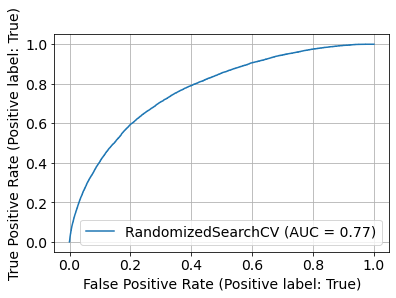

-------------------------------------------------------------
Training Precision-Recall Curve :


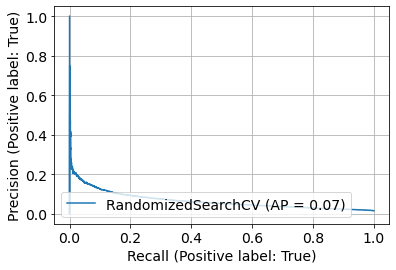

-------------------------------------------------------------


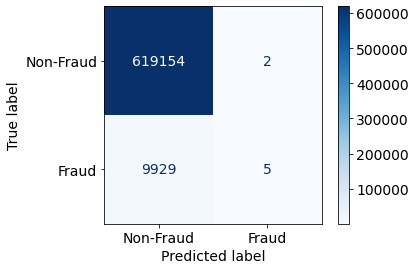

In [ ]:
train_model_results("AdaBoost",grid_search_adb, train_prepared_adb, train_labels)

Testing Results for AdaBoost

-------------------------------------------------------------
Testing Accuracy: 0.06519978253037058
Testing ROC AUC Score: 0.7669414126012306
Testing AP Score: 0.06519978253037058
-------------------------------------------------------------
Testing classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.98      1.00      0.99    154790
       Fraud       0.00      0.00      0.00      2483

    accuracy                           0.98    157273
   macro avg       0.49      0.50      0.50    157273
weighted avg       0.97      0.98      0.98    157273

-------------------------------------------------------------
Testing ROC Curve :


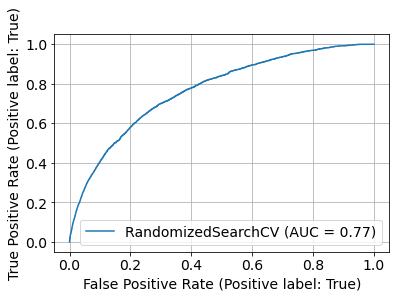

-------------------------------------------------------------
Testing Precision-Recall Curve :


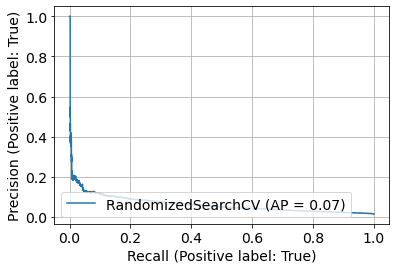

-------------------------------------------------------------


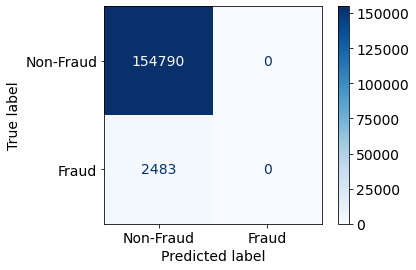

In [ ]:
test_model_results("AdaBoost",grid_search_adb,test_prepared_adb)

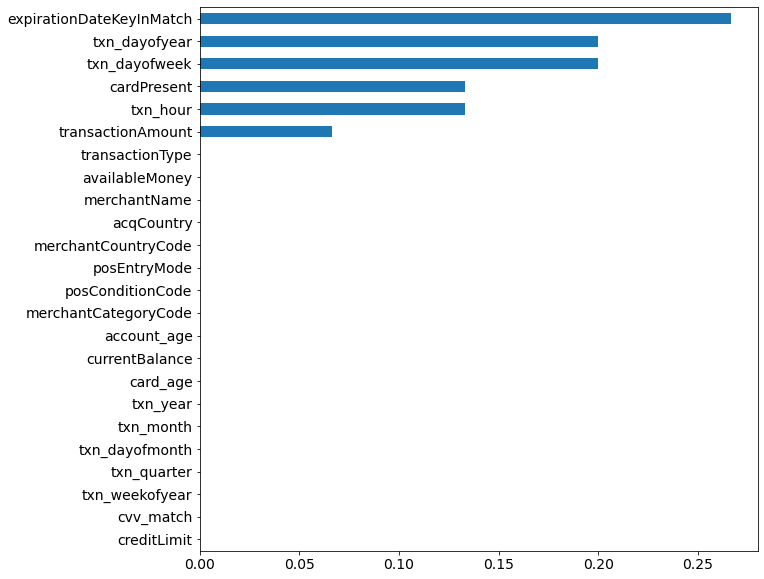

In [ ]:
feature_importance(grid_search_adb.best_estimator_)

## Catboost

In [ ]:
train_cat = train_add_features.copy()
test_cat = test_add_features.copy()

### Prepare Data

In [ ]:
num_cols,obj_cols,date_cols = dtype_sep(train_cat) 

In [ ]:
from sklearn.impute import SimpleImputer

def imputer(imputation_stats):
    if imputation_stats == "median":
      imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    if imputation_stats == "mode":
      imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    
    return imputer 
    

def impute_missingness(df, columns, imputer, dataset_name):
  
  df_imputed = df.copy()
  
  for col in columns: 
    if df[col].dtype == 'datetime64[ns]':
      df[col] = df[col].astype('object')
    
    if dataset_name == "train":
        df_imputed[col] = imputer.fit_transform(df[col].values.reshape(-1,1))[:,0]
    else:
        df_imputed[col] = imputer.transform(df[col].values.reshape(-1,1))[:,0]

  return df_imputed

In [ ]:
cat_imputer = imputer("mode")
# numerical_imputer = imputer("median")

## train data imputation for logistic regression

#Impute NUMERICAL variables 
# train_imputed_cat = impute_missingness(train_cat, num_cols, numerical_imputer, "train")

#Impute categorical variables 
train_prepared_cat = impute_missingness(train_cat, obj_cols, cat_imputer, "train")

## test data imputation for logistic regression

#Impute NUMERICAL variables 
# test_imputed_cat = impute_missingness(test_cat, num_cols, numerical_imputer, "test")

#Impute categorical variables 
test_prepared_cat = impute_missingness(test_cat, obj_cols, cat_imputer, "test")

### Train model

In [ ]:
# Stratified K-folds of CV
kfold_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

**catboost needs missing value imputation for categorical features**

**catboost needs numerical values in outputs for binary classification**

**catboost can takes erither numerical or strings for output labels in multi class classification**

https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier_fit

In [ ]:
categorical_features_indices = np.where(train_cat.dtypes == object)[0]

In [ ]:
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [ ]:
train_labels = train_labels.astype('int64')

In [ ]:
test_labels = test_labels.astype('int64')

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import time

start_time = time.time()

#check which hyperparamters to use
param_grid = {'learning_rate': [0.001,0.01,0.1],
        'depth': [4,6,8,10],
        'iterations': [200,300],
        'l2_leaf_reg':range(2,9,2),
        'scale_pos_weight':[40,50,60]}
 

catboost_cls = CatBoostClassifier(verbose = False,random_seed=42,task_type = 'GPU')

# train across 5 folds se
grid_search_cat = RandomizedSearchCV(catboost_cls, param_grid, cv=kfold_cv,
                          scoring=('roc_auc', 'average_precision','recall','precision','f1'), 
                          refit = 'average_precision',
                          return_train_score=True,
                          n_jobs = -1,n_iter = 100)

grid_search_cat.fit(train_prepared_cat, train_labels,cat_features= categorical_features_indices)

print("elapsed time in seconds: ", time.time() - start_time) 

elapsed time in seconds:  19973.82813644409


#### Save Best Model

In [ ]:
#save model
save_model(grid_search_cat, "catboost")

In [ ]:
# load model
grid_search_cat = joblib.load('catboost_2023-03-01T02:13.pkl')

In [ ]:
print(f"Best Hyperparameters: {grid_search_cat.best_params_}")
print(f"validation Mean Average Precision: {grid_search_cat.best_score_}")

Best Hyperparameters: {'scale_pos_weight': 40, 'learning_rate': 0.1, 'l2_leaf_reg': 8, 'iterations': 300, 'depth': 8}
validation Mean Average Precision: 0.1243453053387826


#### Cross Validation Result

In [ ]:
cvres = grid_search_cat.cv_results_ 

In [ ]:
cvres_df = pd.DataFrame(cvres)
# Select required Columns
cvres_df = cvres_df[['params',
          'mean_train_average_precision','mean_train_roc_auc','mean_train_recall', 'mean_train_precision','mean_train_f1', 
          'mean_test_average_precision','mean_test_roc_auc','mean_test_recall','mean_test_precision', 'mean_test_f1', 
          'mean_fit_time']]

# Rename Columns 
cvres_df.rename(columns={"mean_train_average_precision": "Train_AP", "mean_train_roc_auc": "Train_ROC_AUC", 
                         "mean_train_recall": "Train_Recall","mean_train_precision": "Train_Precision", "mean_train_f1": "Train_F1",
                         "mean_test_average_precision": "Val_AP", "mean_test_roc_auc": "Val_ROC_AUC", 
                         "mean_test_recall": "Val_Recall","mean_test_precision": "Val_Precision", "mean_test_f1": "Val_F1"}, inplace=True)
cvres_df.round(2)

,params,Train_AP,Train_ROC_AUC,Train_Recall,Train_Precision,Train_F1,Val_AP,Val_ROC_AUC,Val_Recall,Val_Precision,Val_F1,mean_fit_time
0,"{'scale_pos_weight': 60, 'learning_rate': 0.01...",0.10,0.82,0.73,0.05,0.09,0.09,0.80,0.70,0.04,0.08,90.56
1,"{'scale_pos_weight': 60, 'learning_rate': 0.1,...",0.10,0.82,0.73,0.04,0.08,0.09,0.80,0.71,0.04,0.08,28.66
2,"{'scale_pos_weight': 60, 'learning_rate': 0.01...",0.10,0.82,0.73,0.05,0.09,0.09,0.80,0.70,0.04,0.08,83.29
3,"{'scale_pos_weight': 60, 'learning_rate': 0.01...",0.07,0.78,0.70,0.04,0.07,0.07,0.77,0.69,0.04,0.07,45.46
4,"{'scale_pos_weight': 40, 'learning_rate': 0.01...",0.10,0.82,0.59,0.06,0.11,0.09,0.80,0.56,0.06,0.10,87.26
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"{'scale_pos_weight': 50, 'learning_rate': 0.1,...",0.14,0.85,0.71,0.06,0.11,0.11,0.81,0.65,0.05,0.10,37.97
96,"{'scale_pos_weight': 60, 'learning_rate': 0.1,...",0.13,0.85,0.76,0.05,0.09,0.11,0.81,0.70,0.05,0.09,39.70
97,"{'scale_pos_weight': 40, 'learning_rate': 0.1,...",0.14,0.85,0.65,0.07,0.12,0.12,0.81,0.58,0.06,0.11,38.28
98,"{'scale_pos_weight': 40, 'learning_rate': 0.00...",0.06,0.77,0.49,0.05,0.09,0.06,0.77,0.49,0.05,0.09,37.76


Training Results for CatBoost

-------------------------------------------------------------
Training Accuracy: 0.23174560158391713
Training ROC AUC Score: 0.9096542931495346
Training AP Score: 0.23174560158391713
-------------------------------------------------------------
Training classification report :
              precision    recall  f1-score   support

   Non-Fraud       1.00      0.88      0.93    619156
       Fraud       0.09      0.75      0.16      9934

    accuracy                           0.88    629090
   macro avg       0.54      0.81      0.55    629090
weighted avg       0.98      0.88      0.92    629090

-------------------------------------------------------------
Training ROC Curve :


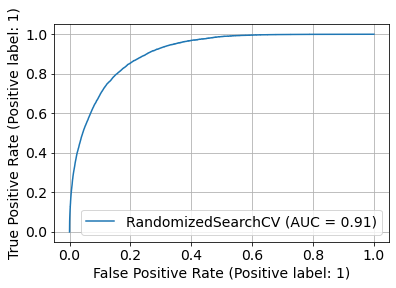

-------------------------------------------------------------
Training Precision-Recall Curve :


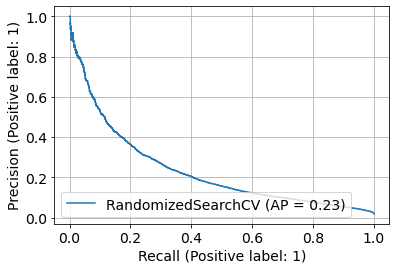

-------------------------------------------------------------


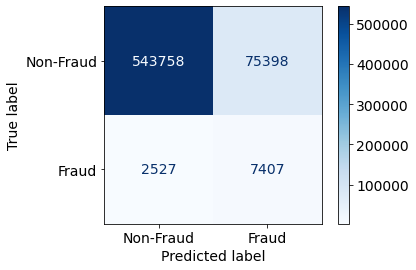

In [ ]:
train_model_results("CatBoost",grid_search_cat, train_prepared_cat, train_labels)

Testing Results for CatBoost

-------------------------------------------------------------
Testing Accuracy: 0.12118314925638421
Testing ROC AUC Score: 0.8113700197976512
Testing AP Score: 0.12118314925638421
-------------------------------------------------------------
Testing classification report :
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.88      0.93    154790
       Fraud       0.07      0.55      0.12      2483

    accuracy                           0.87    157273
   macro avg       0.53      0.71      0.52    157273
weighted avg       0.98      0.87      0.92    157273

-------------------------------------------------------------
Testing ROC Curve :


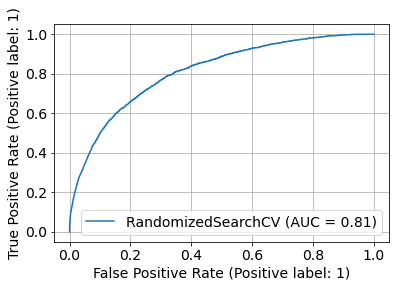

-------------------------------------------------------------
Testing Precision-Recall Curve :


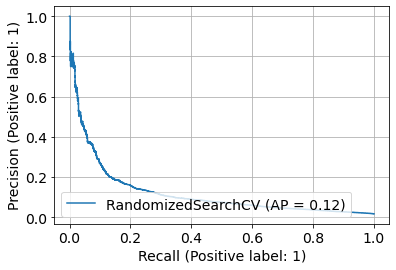

-------------------------------------------------------------


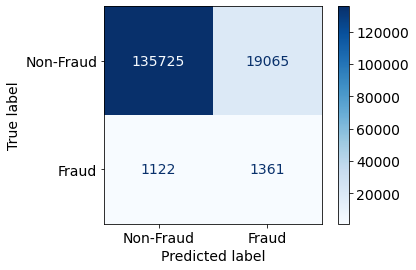

In [ ]:
test_model_results("CatBoost",grid_search_cat,test_prepared_cat)

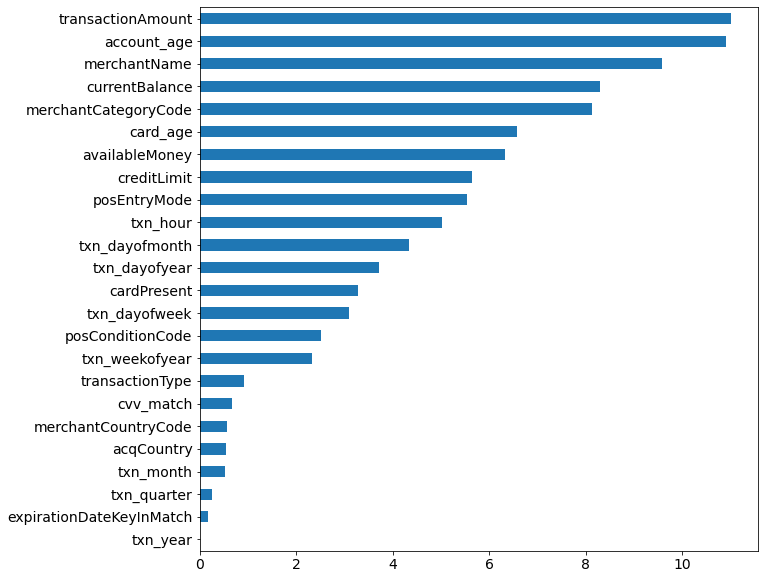

In [ ]:
feature_importance(grid_search_cat.best_estimator_)